In [1]:
from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sns.set_theme(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", 100)

# 데이터 이해 및 탐색

In [4]:
# 데이터
data = load_breast_cancer(as_frame=True)
X, y = data.data, data.target
feature_names = data.feature_names
class_names = data.target_names  # malignant: 악성의, 해로운, benign: 양성의, 해가 거의 없는

In [5]:
feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [6]:
class_names

array(['malignant', 'benign'], dtype='<U9')

In [7]:
df = pd.concat([X, y], axis=1)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [8]:
# 크기/결측치/타입
print("[+] Shape:", df.shape)
print("\n[+] Dtypes:\n", df.dtypes.value_counts())
print("\n[+] Missing values (sum):\n", df.isna().sum())

[+] Shape: (569, 31)

[+] Dtypes:
 float64    30
int64       1
Name: count, dtype: int64

[+] Missing values (sum):
 mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target       

# 타깃 분포(클래스 불균형 확인)

In [9]:
counts = y.value_counts().sort_index()
ratios = y.value_counts(normalize=True).sort_index()
print("Counts:\n", counts.map(int))
print("\nRatios:\n", (ratios*100).round(2).astype(str) + "%")

Counts:
 target
0    212
1    357
Name: count, dtype: int64

Ratios:
 target
0    37.26%
1    62.74%
Name: proportion, dtype: object


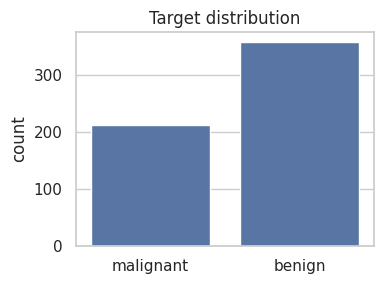

In [10]:
plt.figure(figsize=(4,3))
sns.barplot(x=[class_names[i] for i in counts.index], y=counts.values)
plt.title("Target distribution")
plt.ylabel("count"); plt.xlabel("")
plt.tight_layout(); plt.show()

# 기술통계(전체/그룹별)

In [11]:
X.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.13,3.52,6.98,11.70,13.37,15.78,28.11
mean texture,569.0,19.29,4.30,9.71,16.17,18.84,21.80,39.28
mean perimeter,569.0,91.97,24.30,43.79,75.17,86.24,104.10,188.50
mean area,569.0,654.89,351.91,143.50,420.30,551.10,782.70,2501.00
mean smoothness,569.0,0.10,0.01,0.05,0.09,0.10,0.11,0.16
mean compactness,569.0,0.10,0.05,0.02,0.06,0.09,0.13,0.35
mean concavity,569.0,0.09,0.08,0.00,0.03,0.06,0.13,0.43
mean concave points,569.0,0.05,0.04,0.00,0.02,0.03,0.07,0.20
mean symmetry,569.0,0.18,0.03,0.11,0.16,0.18,0.20,0.30
mean fractal dimension,569.0,0.06,0.01,0.05,0.06,0.06,0.07,0.10


In [12]:
group_desc = df.groupby("target").agg(['mean', 'min', 'max']).T
group_desc.columns = [class_names[i] for i in group_desc.columns]
with pd.option_context('display.max_rows', None):
    display(group_desc)

malignant       benign
mean radius             mean    17.462830    12.146524
                        min     10.950000     6.981000
                        max     28.110000    17.850000
mean texture            mean    21.604906    17.914762
                        min     10.380000     9.710000
                        max     39.280000    33.810000
mean perimeter          mean   115.365377    78.075406
                        min     71.900000    43.790000
                        max    188.500000   114.600000
mean area               mean   978.376415   462.790196
                        min    361.600000   143.500000
                        max   2501.000000   992.100000
mean smoothness         mean     0.102898     0.092478
                        min      0.073710     0.052630
                        max      0.144700     0.163400
mean compactness        mean     0.145188     0.080085
                        min      0.046050     0.019380
                        max      0.345400     0.223900
mean concavity          mean     0.160775     0.046058
                        min      0.023980     0.000000
                        max      0.426800     0.410800
mean concave points     mean     0.087990     0.025717
                        min      0.020310     0.000000
                        max      0.201200     0.085340
mean symmetry           mean     0.192909     0.174186
                        min      0.130800     0.106000
                        max      0.304000     0.274300
mean fractal dimension  mean     0.062680     0.062867
                        min      0.049960     0.051850
                        max      0.097440     0.095750
radius error            mean     0.609083     0.284082
                        min      0.193800     0.111500
                        max      2.873000     0.881100
texture error           mean     1.210915     1.220380
                        min      0.362100     0.360200
                        max      3.568000     4.885000
perimeter error         mean     4.323929     2.000321
                        min      1.334000     0.757000
                        max     21.980000     5.118000
area error              mean    72.672406    21.135148
                        min     13.990000     6.802000
                        max    542.200000    77.110000
smoothness error        mean     0.006780     0.007196
                        min      0.002667     0.001713
                        max      0.031130     0.021770
compactness error       mean     0.032281     0.021438
                        min      0.008422     0.002252
                        max      0.135400     0.106400
concavity error         mean     0.041824     0.025997
                        min      0.011010     0.000000
                        max      0.143800     0.396000
concave points error    mean     0.015060     0.009858
                        min      0.005174     0.000000
                        max      0.040900     0.052790
symmetry error          mean     0.020472     0.020584
                        min      0.007882     0.009539
                        max      0.078950     0.061460
fractal dimension error mean     0.004062     0.003636
                        min      0.001087     0.000895
                        max      0.012840     0.029840
worst radius            mean    21.134811    13.379801
                        min     12.840000     7.930000
                        max     36.040000    19.820000
worst texture           mean    29.318208    23.515070
                        min     16.670000    12.020000
                        max     49.540000    41.780000
worst perimeter         mean   141.370330    87.005938
                        min     85.100000    50.410000
                        max    251.200000   127.100000
worst area              mean  1422.286321   558.899440
                        min    508.100000   185.200000
                        max   4254.000000  1210.000000
worst smoothness 

# 학습용 데이터 생성

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
X.shape, y.shape

((569, 30), (569,))

In [20]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [22]:
X_tr.shape, y_tr.shape

((426, 30), (426,))

In [23]:
X_te.shape, y_te.shape

((143, 30), (143,))

# 모델 생성

In [25]:
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, oob_score=True
)

# 학습

In [26]:
rf.fit(X_tr, y_tr)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


# 검증

In [29]:
y_pr = rf.predict(X_te)
print("Acc:", accuracy_score(y_te, y_pr))
print("OOB score:", rf.oob_score_)

Acc: 0.958041958041958
OOB score: 0.9624413145539906


## 성능평가

In [40]:
print(classification_report(y_te, y_pr))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        53
           1       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



## 혼동 행렬

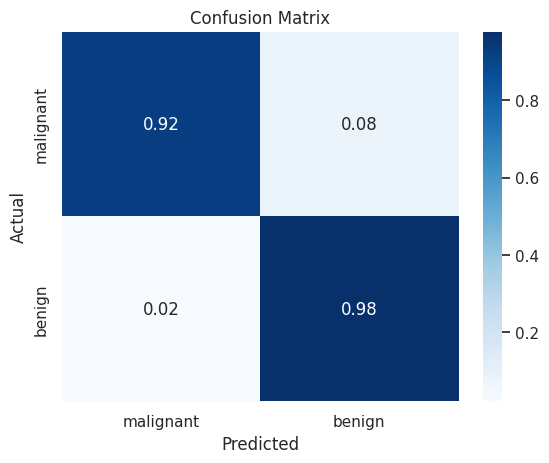

In [52]:
conf_mat = confusion_matrix(y_te, y_pr, normalize='true')
sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Gini(불순도) 기반 중요도
- 학습중 각 특징을 써서 불순도를 얼마나 줄였는가를 누적해 측정

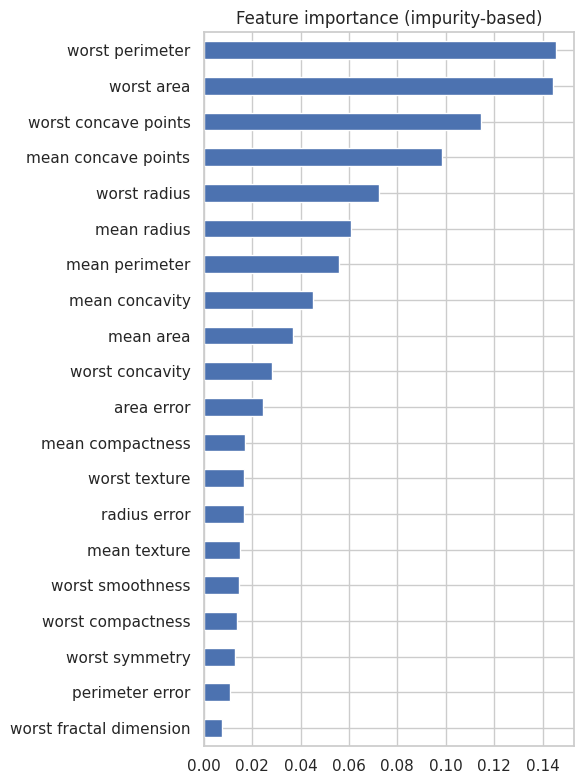

In [53]:
imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=True)
plt.figure(figsize=(6, 8))
imp.tail(20).plot(kind="barh")
plt.title("Feature importance (impurity-based)")
plt.tight_layout()
plt.show()

## Permutation Importance (권장)
- 학습된 모델을 고정하고, 특정 특징 값을 셔플해 성능이 얼마나 떨어지는지로 측정
- 성능이 많이 떨어지는 Feature는 중요도가 높다는 의미로 해석

In [54]:
from sklearn.inspection import permutation_importance

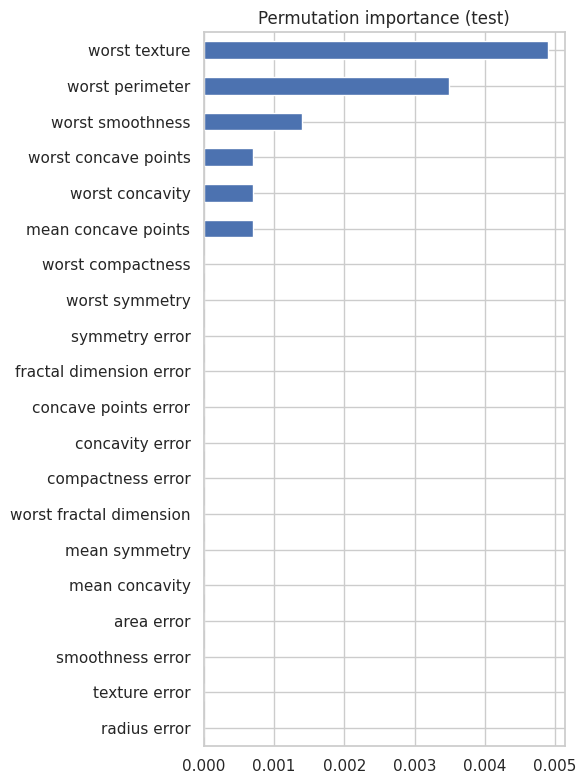

In [55]:
perm = permutation_importance(
    rf, X_te, y_te, n_repeats=10, random_state=42, n_jobs=-1
)
pi = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(6, 8))
pi.tail(20).plot(kind="barh")
plt.title("Permutation importance (test)")
plt.tight_layout()
plt.show()


## 개별 트리 시각화

In [56]:
from sklearn import tree
import graphviz

In [57]:
est = rf.estimators_[0]  # 첫 번째 나무

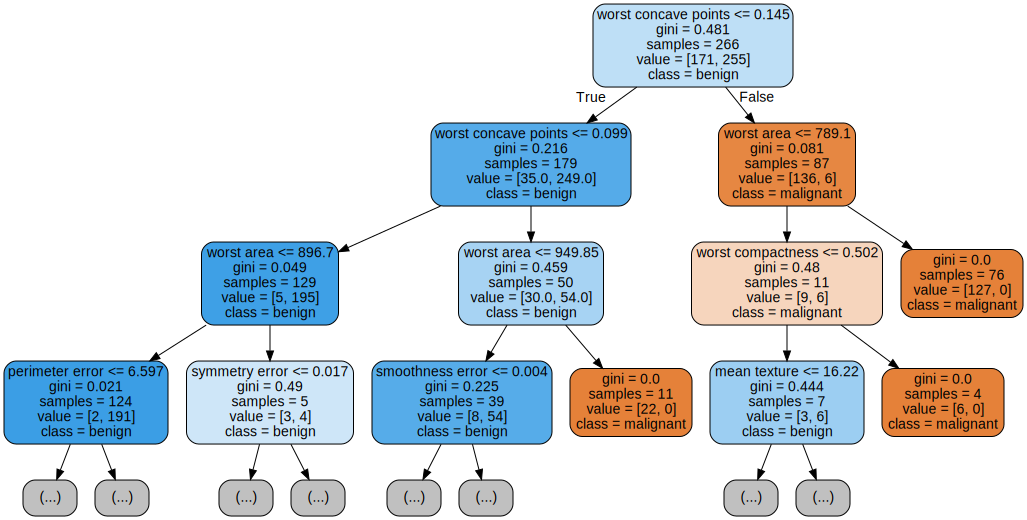

In [58]:
dot = tree.export_graphviz(
    est,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names,
    filled=True, rounded=True, max_depth=3
)
graphviz.Source(dot)  # 노트북에 바로 표시